# Project: Investigating "No-show appointments" Dataset.

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This dataset collects information from 100,000 medical appointments in Brazil. A number of characteristics about each patient are included in each row.

>###  In our analysis, we're trying to find answers for 3 questions:
>####     Q1) What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?
>####      Q2) Are hypertensive patients in our dataset more likely to have other diseases?
>####      Q3)  How aging affects the other variables in our dataset?

In [2]:
# This cell is to set up import statements for all of the packages that we plan to use.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

% matplotlib inline

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [3]:
# We Load our data and print out a few lines.

df = pd.read_csv('no_show_appointments.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


> We make column labels lower case letters and replace hyphens with underscores

In [4]:
df.columns = [c.strip().lower().replace('-','_') for c in df.columns]

> We convert categorical values from to quantitative values (0,1) so that we can see their statistical properties.

In [5]:
df['no_show'].replace(['No', 'Yes'], [0,1], inplace = True)
df['gender'].replace(['M', 'F'], [0,1], inplace = True) 

> We find the shape of the dataset, the number of non-null values and datatypes of each column for consistency.

In [6]:
df.shape

(110527, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patientid         110527 non-null float64
appointmentid     110527 non-null int64
gender            110527 non-null int64
scheduledday      110527 non-null object
appointmentday    110527 non-null object
age               110527 non-null int64
neighbourhood     110527 non-null object
scholarship       110527 non-null int64
hipertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handcap           110527 non-null int64
sms_received      110527 non-null int64
no_show           110527 non-null int64
dtypes: float64(1), int64(10), object(3)
memory usage: 11.8+ MB


> We look for the number of null values and duplicates.

In [8]:
df.isnull().sum()

patientid         0
appointmentid     0
gender            0
scheduledday      0
appointmentday    0
age               0
neighbourhood     0
scholarship       0
hipertension      0
diabetes          0
alcoholism        0
handcap           0
sms_received      0
no_show           0
dtype: int64

In [9]:
sum(df.duplicated())

0

> We drop the unneeded columns from the dataset.

In [10]:
df.drop(['appointmentid','patientid'],axis=1,inplace=True)

> We convert the datatype of dates from objects to datetime.

In [11]:
df.scheduledday = pd.to_datetime(df.scheduledday)

In [12]:
df.appointmentday = pd.to_datetime(df.appointmentday)

> We create a new column (time_diff) for the period between the scheduled day and the appointment day.

In [13]:
df['time_diff'] = (df['appointmentday'] - df['scheduledday']).dt.days

> We explore some statistical characterestics of the dataset with visualizations.

In [14]:
df.describe()

,gender,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,time_diff
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.649977,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000


> We remove the rows where age is given in negative values and continue exploring the statistical properties.

In [15]:
a=df.query('age <0')
df.drop(a.index, inplace=True)

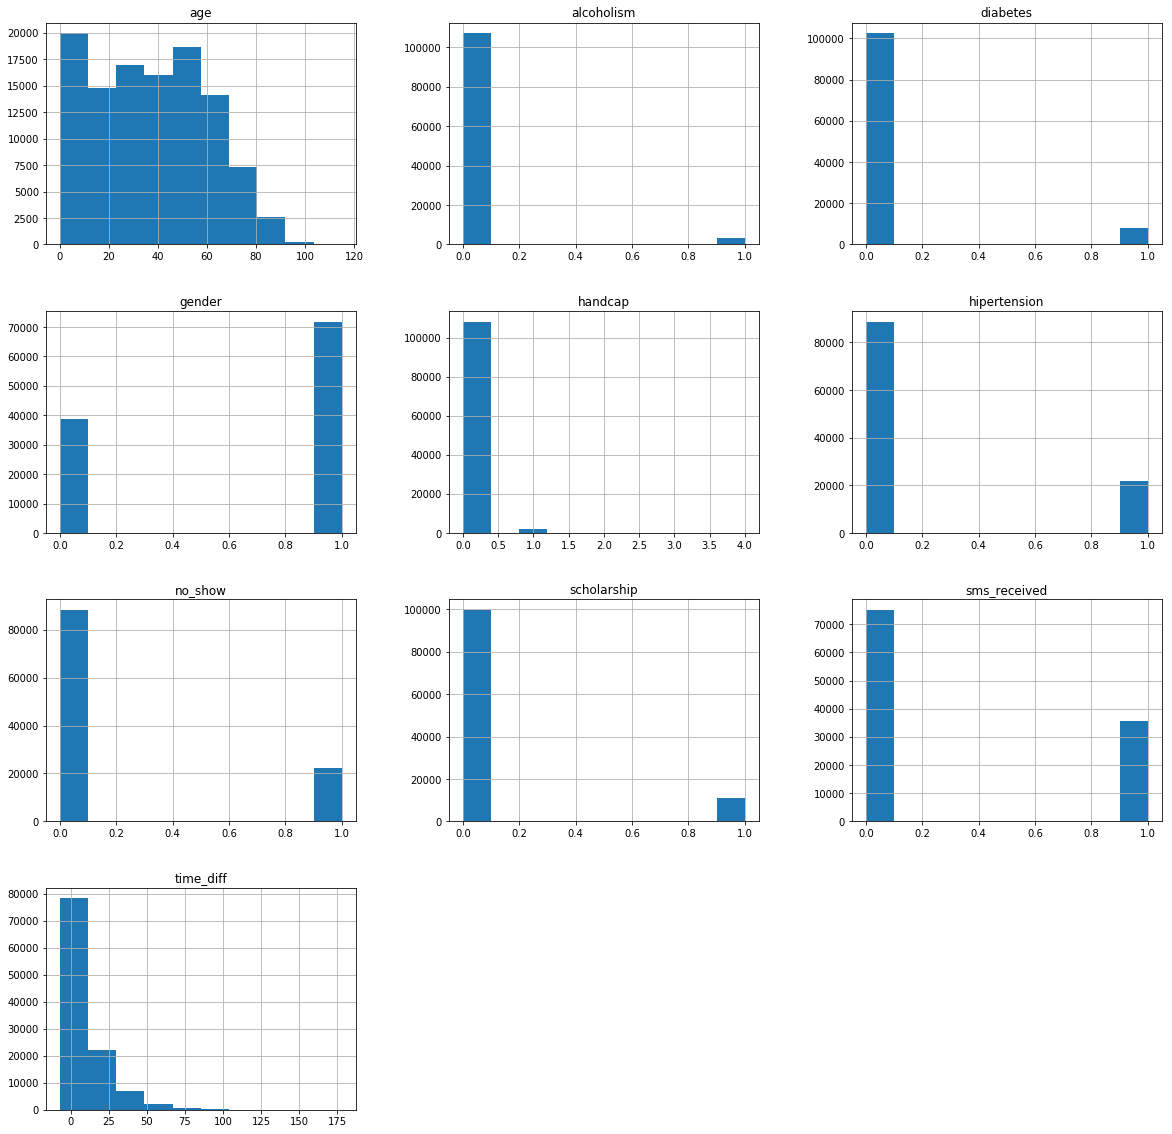

In [16]:
df.hist(figsize=(20,20));

In [17]:
df.corr()

,gender,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,time_diff
gender,1.000000,0.106452,0.114296,0.055722,0.032556,-0.106166,-0.022813,0.046302,0.004122,0.028411
age,0.106452,1.000000,-0.092463,0.504586,0.292391,0.095810,0.078032,0.012633,-0.060327,0.034811
scholarship,0.114296,-0.092463,1.000000,-0.019730,-0.024894,0.035022,-0.008587,0.001192,0.029134,-0.030423
hipertension,0.055722,0.504586,-0.019730,1.000000,0.433085,0.087970,0.080083,-0.006270,-0.035704,-0.017218
diabetes,0.032556,0.292391,-0.024894,0.433085,1.000000,0.018473,0.057530,-0.014552,-0.015181,-0.027190
alcoholism,-0.106166,0.095810,0.035022,0.087970,0.018473,1.000000,0.004647,-0.026149,-0.000197,-0.038520
handcap,-0.022813,0.078032,-0.008587,0.080083,0.057530,0.004647,1.000000,-0.024162,-0.006077,-0.019844
sms_received,0.046302,0.012633,0.001192,-0.006270,-0.014552,-0.026149,-0.024162,1.000000,0.126428,0.398143
no_show,0.004122,-0.060327,0.029134,-0.035704,-0.015181,-0.000197,-0.006077,0.126428,1.000000,0.186228
time_diff,0.028411,0.034811,-0.030423,-0.017218,-0.027190,-0.038520,-0.019844,0.398143,0.186228,1.000000


> we look for the associations between the quantitaive variables in the correlation matrix above. We notice that not showing up for the appointment is direcly related to the number of sms messages received (12.6%)and time difference (18.6%).

> We draw the correlation matrix below.

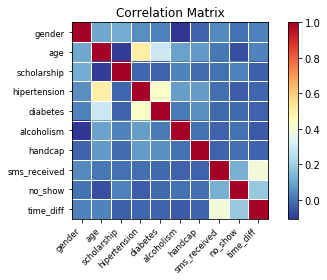

In [18]:
matrix = df.corr()
sm.graphics.plot_corr(matrix, xnames=list(matrix.columns))
plt.show()

### Data Cleaning

> There are no null values and no duplicates in the dataset.

> We correct the syntax in the column labels.

In [19]:
df.rename({'hipertension':'hypertension'}, axis=1, inplace=True)
df.rename({'handcap': 'handicap'}, axis=1, inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis

> Now that we've trimmed and cleaned our data, we're ready to move on to exploration. We compute statistics and create visualizations with the goal of addressing the research questions that we posed in the Introduction section.

### Research Question 1 (What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?)

> We look at the correlation between not showing up for the appointment and other variables.

In [20]:
df.corrwith(df['no_show'])

gender          0.004122
age            -0.060327
scholarship     0.029134
hypertension   -0.035704
diabetes       -0.015181
alcoholism     -0.000197
handicap       -0.006077
sms_received    0.126428
no_show         1.000000
time_diff       0.186228
dtype: float64

> We notice that not showing up for the appointment is direcly related to the number of sms messages received (12.6%)and time difference (18.6%).

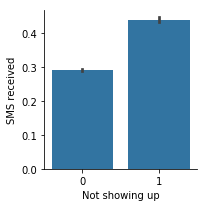

In [37]:
sns.FacetGrid(df).map(sns.barplot, "no_show", "sms_received", order=[0,1]);
plt.xlabel('Not showing up')
plt.ylabel('SMS received')
plt.show()

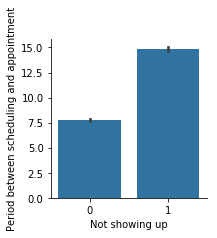

In [38]:
sns.FacetGrid(df).map(sns.barplot, "no_show", "time_diff", order=[0,1]);
plt.xlabel('Not showing up')
plt.ylabel('Period between scheduling and appointment')
plt.show()

> Next, we investigate the relationship between the locations and not showing up for the appointment.

> We find the locations that have more than 500 patient to reduce the skewing of data and assign these patients (the rows) to a new DataFrame (x).

In [23]:
x=df[df['neighbourhood'].map(df['neighbourhood'].value_counts()) >500]

> We plot a bar chart showing the top 10 locations where the patients are most likely not to show up for their appointments (df.no_show == 1) (measured using the mean)

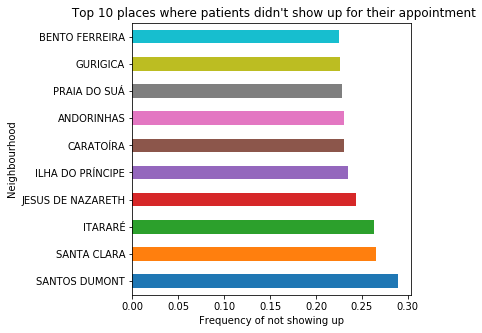

In [30]:
x.groupby('neighbourhood').no_show.mean().sort_values(ascending=False).head(10).plot.barh(figsize=(5,5), title=' Top 10 places where patients didn\'t show up for their appointment');
plt.xlabel('Frequency of not showing up')
plt.ylabel('Neighbourhood')
plt.show()

> We plot a bar chart showing the top 10 locations where the patients are most likely to show up for their appointments (df.no_show == 00) (measured using the mean)

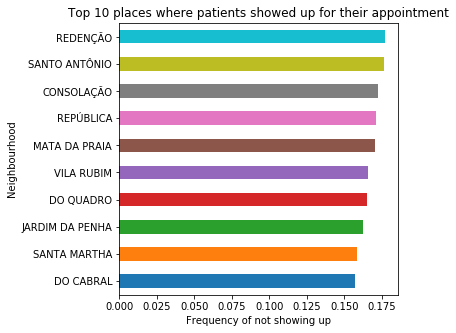

In [31]:
x.groupby('neighbourhood').no_show.mean().sort_values(ascending=True).head(10).plot.barh(figsize=(5,5), title='Top 10 places where patients showed up for their appointment');
plt.xlabel('Frequency of not showing up')
plt.ylabel('Neighbourhood')
plt.show()

> We create a new dataframe (ns (not_showing_up)) and assign to it the patients who didn't show up for their appointment. Then, we use the new dataframe to find the top 10 locations where patients didn't show up for their appointment.


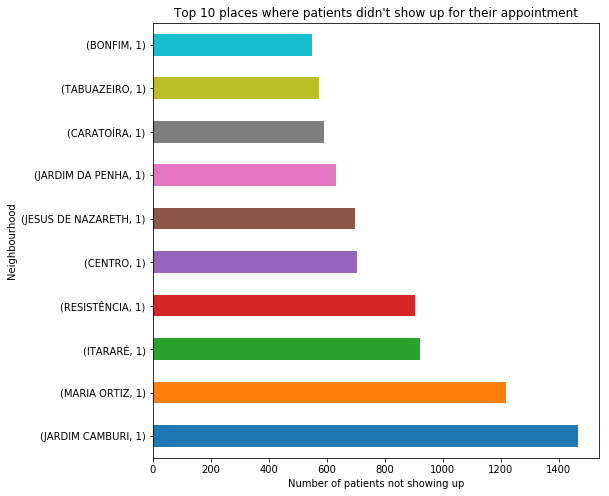

In [32]:
ns = x.query('no_show==1')
ns.groupby('neighbourhood').no_show.value_counts().sort_values(ascending=False).head(10).plot.barh(figsize=(8,8), title= 'Top 10 places where patients didn\'t show up for their appointment');
plt.xlabel('Number of patients not showing up')
plt.ylabel('Neighbourhood')
plt.show()

> We create a new dataframe (s (showing_up)) and assign to it the patients who showed up for their appointment. Then, we use the new dataframe to find the top 10 locations where patients showed up for their appointment.

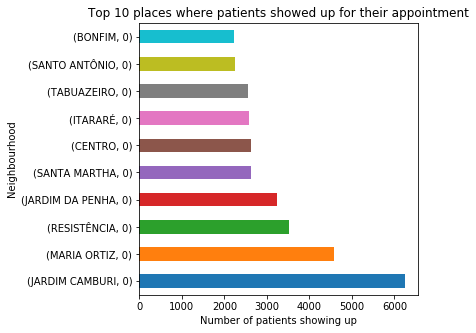

In [35]:
s = x.query('no_show==0')
s.groupby('neighbourhood').no_show.value_counts().sort_values(ascending=False).head(10).plot.barh(figsize=(5,5), title='Top 10 places where patients showed up for their appointment');
plt.xlabel('Number of patients showing up')
plt.ylabel('Neighbourhood')
plt.show()

### Research Question 2  (Are hypertensive patients more likely to have other diseases?)

> We look at the correlation between having hypertension and the other variables in the dataset.

In [27]:
df.corrwith(df['hypertension'])

gender          0.055722
age             0.504586
scholarship    -0.019730
hypertension    1.000000
diabetes        0.433085
alcoholism      0.087970
handicap        0.080083
sms_received   -0.006270
no_show        -0.035704
time_diff      -0.017218
dtype: float64

> From above, We notice that the hypertensive patients are more likely to increase with age and to also have diabetes, alcoholism, and handicaps.

In [28]:
df.groupby('hypertension').diabetes.mean()

hypertension
0    0.016422
1    0.297509
Name: diabetes, dtype: float64

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


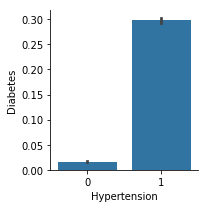

In [36]:
sns.FacetGrid(df).map(sns.barplot, "hypertension", "diabetes");
plt.xlabel('Hypertension')
plt.ylabel('Diabetes')
plt.show()

In [30]:
df.groupby('hypertension').alcoholism.mean()

hypertension
0    0.022913
1    0.060869
Name: alcoholism, dtype: float64

In [31]:
df.groupby('hypertension').handicap.mean()

hypertension
0    0.015835
1    0.048346
Name: handicap, dtype: float64

### Research Question 3  (What variables are directly related to with aging?)

> We look at the correlation between the age and the other variables in the dataset.

In [32]:
df.corrwith(df['age'])

gender          0.106452
age             1.000000
scholarship    -0.092463
hypertension    0.504586
diabetes        0.292391
alcoholism      0.095810
handicap        0.078032
sms_received    0.012633
no_show        -0.060327
time_diff       0.034811
dtype: float64

> From above, we find that aging is directly related to having hypertension, diabetes, alcoholism. Also aging is inversely related to having a scholarship

In [33]:
df.groupby('hypertension').age.mean()

hypertension
0    31.308943
1    60.613596
Name: age, dtype: float64

In [34]:
df.groupby('diabetes').age.mean()

diabetes
0    35.208962
1    61.372529
Name: age, dtype: float64

In [35]:
df.groupby('alcoholism').age.mean()

alcoholism
0    36.697161
1    49.593750
Name: age, dtype: float64

In [36]:
df.groupby('scholarship').age.mean()

scholarship
0    37.794612
1    30.616242
Name: age, dtype: float64

<a id='conclusions'></a>
## Conclusions

>###  In our analysis, we posed 3 questions:
>####     Q1) What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

>We looked at the correlation between not showing up for the appointment and the other variables in the dataset.

We found that not showing up for the appointment is direcly related to the number of SMS messages received (12.6%)and time difference (18.6%). Also, we created visulaization to show which places the patients were most likely not to show up and to show up.

>####      Q2) Are hypertensive patients in our dataset more likely to have other diseases?

> We looked at the correlation between having hypertension and the other variables in the dataset.

We noticed that the hypertensive patients are more likely to increase with age and to also have diabetes, alcoholism, and handicaps.

>####      Q3)  How aging affects the other variables in our dataset?

> We looked at the correlation between the age and the other variables in the dataset.

we concluded that aging is directly related to having hypertension, diabetes, alcoholism and that aging is also inversely related to having a scholarship.

## Limitations:

1) Most variables are categorical, we don't have values for hypertension or diabetes. We only know if the patient have them or not. This may mislead our analysis.

2) We didn't divide the age into different groups. This may lead to wrong correlations as we didn't know at what age the variables increase or decrease in their relation to the age.

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0